#### ***End-to-End ECG Signal Analysis and Machine Learning Pipeline***

***Introduction***
Welcome to this comprehensive guide on building an end-to-end machine learning pipeline for physiological time-series data. In this notebook, we will embark on a complete data science journey, starting from a raw, real-world signal and finishing with trained machine learning models and insightful visualizations.

Our goal is to take an **electrocardiogram (ECG)** signal from the MHEALTH dataset, transform it into a structured format, and then use it to automatically classify human activities. We will cover:

1. Data Loading & Preparation: Sourcing and preparing real-world sensor data.

2. Feature Extraction: Converting raw signal windows into meaningful statistical features.

3. Supervised Learning: Training a Random Forest model to classify activities based on our features.

4. Unsupervised Learning: Discovering hidden patterns and anomalies using Clustering and Anomaly Detection.

5. Exploratory Data Analysis (EDA): Creating powerful visualizations to understand our data and model performance.

#### ***Part 1: Data Loading and Preparation***

**The Need for Real Data**
To build a practical and robust model, we must start with real-world data. We will use the MHEALTH (Mobile Health) dataset, which contains recordings from various sensors placed on the human body. This first step involves programmatically downloading the data, loading it into a structured format using the pandas library, and preparing it for analysis by creating a proper time-series index.

In [1]:
import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import requests
import zipfile
import io
import os

In [2]:
# --- 1. Load a Real-World Dataset (MHEALTH Dataset) ---

# URL for the dataset zip file from the UCI repository
DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00319/MHEALTHDATASET.zip"
LOG_FILE_NAME = "mHealth_subject1.log"

# Download and extract the data if not already present
if not os.path.exists(LOG_FILE_NAME):
    print(f"🌎 Downloading and extracting data from {DATASET_URL}...")
    response = requests.get(DATASET_URL)
    z = zipfile.ZipFile(io.BytesIO(response.content))
    # The zip file contains a directory, so we need to find the specific file
    for file_info in z.infolist():
        if LOG_FILE_NAME in file_info.filename:
            file_data = z.read(file_info.filename)
            with open(LOG_FILE_NAME, 'wb') as f:
                f.write(file_data)
            break
    print("✅ Download complete.")

In [3]:
# Define column names as per the dataset's documentation
column_names = [
    'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
    'ecg_lead_1', 'ecg_lead_2',
    'acc_left_ankle_x', 'acc_left_ankle_y', 'acc_left_ankle_z',
    'gyro_left_ankle_x', 'gyro_left_ankle_y', 'gyro_left_ankle_z',
    'mag_left_ankle_x', 'mag_left_ankle_y', 'mag_left_ankle_z',
    'acc_right_lower_arm_x', 'acc_right_lower_arm_y', 'acc_right_lower_arm_z',
    'gyro_right_lower_arm_x', 'gyro_right_lower_arm_y', 'gyro_right_lower_arm_z',
    'mag_right_lower_arm_x', 'mag_right_lower_arm_y', 'mag_right_lower_arm_z',
    'activity_label'
]

In [4]:
# Load the data using pandas
df = pd.read_csv(LOG_FILE_NAME, header=None, sep='\t', names=column_names)

In [5]:
# --- Create a time-series signal ---
# The dataset has a fixed sampling rate of 50 Hz.
fs = 50  # Sampling rate: 50 samples per second

# Create a DatetimeIndex for the DataFrame
total_samples = len(df)
time_index = pd.to_datetime(pd.date_range(start='2025-01-01', periods=total_samples, freq=f'{1/fs}S'))
df.index = time_index

# Select our signal of interest: ECG Lead 1
signal_series = df['ecg_lead_1'].rename('ECG')

print(f"✅ Real-world ECG signal loaded. Sampling Rate: {fs} Hz.")
print(f"Total data points: {len(signal_series)}")

✅ Real-world ECG signal loaded. Sampling Rate: 50 Hz.
Total data points: 161280


/tmp/ipython-input-287326386.py:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_index = pd.to_datetime(pd.date_range(start='2025-01-01', periods=total_samples, freq=f'{1/fs}S'))


#### ***Part 2: Feature Extraction***

***The Need for Feature Engineering***

Machine learning models like Random Forest cannot interpret raw time-series data directly. They require a structured, tabular format where each row is an observation and each column is a descriptive feature. Our task here is to convert the long, continuous ECG signal into this format. We achieve this by sliding a "window" (e.g., 10 seconds) across the signal and calculating a set of descriptive statistics for the data inside each window. These statistics become our features.

We will extract two types of features:
1. Time-Domain Features: Statistics calculated directly on the signal's amplitude values (e.g., mean, standard deviation, min, max).

2. Frequency-Domain Features: Statistics calculated on the signal's frequency components after applying a Fast Fourier Transform (FFT). This helps capture periodic patterns.

In [6]:
# --- 2. Define Feature Extraction Functions (Unchanged) ---

def calculate_rate_of_change(window: pd.Series) -> float:
    """Calculates the average absolute difference between consecutive points."""
    if len(window) < 2:
        return 0.0
    return np.mean(np.abs(np.diff(window)))

def get_dominant_frequency_features(window: pd.Series, sampling_rate: int) -> tuple[float, float]:
    """
    Performs FFT to find the dominant frequency and its power.
    Ignores the DC component (frequency 0).
    """
    n = len(window)
    if n < 2:
        return 0.0, 0.0

    yf = fft(window.to_numpy())
    xf = fftfreq(n, 1 / sampling_rate)

    positive_freq_mask = xf > 0
    xf = xf[positive_freq_mask]
    yf = yf[positive_freq_mask]

    if len(xf) == 0:
        return 0.0, 0.0

    power = np.abs(yf)**2
    max_power_idx = np.argmax(power)
    dominant_freq = xf[max_power_idx]
    dominant_freq_power = power[max_power_idx]

    return dominant_freq, dominant_freq_power

In [8]:
# --- 4. Create the Final Usable DataFrame ---
feature_df = pd.DataFrame(feature_list).set_index('window_start_time')
feature_df.dropna(inplace=True)

print("\n Feature extraction complete!")


 Feature extraction complete!


In [7]:
# --- 3. Process the Signal and Create the Feature Table ---

# Define the window size. Let's use 10-second non-overlapping windows.
window_size = '10S'

feature_list = []

for window_start_time, window_data in signal_series.resample(window_size):
    if window_data.empty:
        continue

    # Calculate all features for this window
    mean_val = window_data.mean()
    std_val = window_data.std()
    min_val = window_data.min()
    max_val = window_data.max()
    roc_val = calculate_rate_of_change(window_data)
    dom_freq, dom_freq_power = get_dominant_frequency_features(window_data, fs)

    feature_list.append({
        'window_start_time': window_start_time,
        'mean': mean_val,
        'std_dev': std_val,
        'variance': std_val**2,
        'min': min_val,
        'max': max_val,
        'rate_of_change': roc_val,
        'dominant_freq': dom_freq,
        'dominant_freq_power': dom_freq_power
    })


/tmp/ipython-input-2493075697.py:8: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  for window_start_time, window_data in signal_series.resample(window_size):


In [9]:
# --- 5. Display the Results ---
print("\n--- Original Signal (First 5 Data Points) ---")
print(signal_series.head())

print(f"\n--- Generated Feature Table (First 5 Windows of {window_size}) ---")
print("Each row represents one 10-second window of data.")
print(feature_df.head())


--- Original Signal (First 5 Data Points) ---
2025-01-01 00:00:00.000    0.004186
2025-01-01 00:00:00.020    0.004186
2025-01-01 00:00:00.040    0.016745
2025-01-01 00:00:00.060    0.079540
2025-01-01 00:00:00.080    0.221870
Freq: 20ms, Name: ECG, dtype: float64

--- Generated Feature Table (First 5 Windows of 10S) ---
Each row represents one 10-second window of data.
                         mean   std_dev  variance      min      max  \
window_start_time                                                     
2025-01-01 00:00:00 -0.070087  0.198372  0.039351 -0.90424  0.86656   
2025-01-01 00:00:10 -0.019098  0.198464  0.039388 -0.82051  1.06750   
2025-01-01 00:00:20 -0.041009  0.316088  0.099912 -1.08840  1.32290   
2025-01-01 00:00:30 -0.026407  0.182487  0.033301 -0.84144  1.04240   
2025-01-01 00:00:40 -0.062208  0.183929  0.033830 -0.84563  0.97959   

                     rate_of_change  dominant_freq  dominant_freq_power  
window_start_time                                      

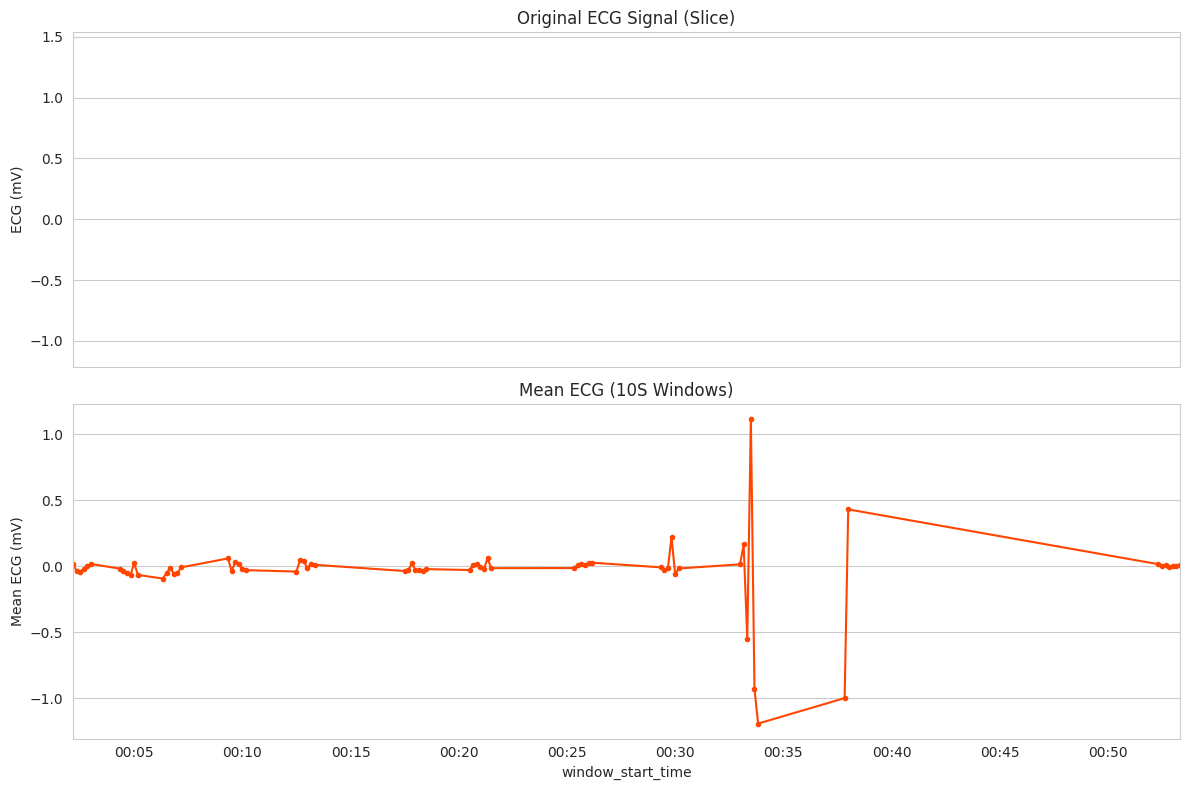

In [22]:
# Optional: Plot the original signal and one of the features
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
# Plot a small slice of the original signal for clarity
signal_series.iloc[:5000].plot(ax=ax[0], title='Original ECG Signal (Slice)', color='royalblue')
ax[0].set_ylabel('ECG (mV)')
feature_df['mean'].plot(ax=ax[1], title=f'Mean ECG ({window_size} Windows)', color='orangered', marker='.')
ax[1].set_ylabel('Mean ECG (mV)')
plt.tight_layout()
# To display the plot, uncomment the line below
plt.show()

#### ***Part 3: Supervised Learning - Classifying Activities***

Now we will use our engineered features to train a model that can predict human activities. This is a supervised learning task because we have ground-truth labels (the actual activity performed) for each moment in time.


***Module 1: Labeling***

The first step is to align the activity_label from our original dataset with the new feature_df. Since each row in feature_df represents a 10-second window, we will assign the most frequent (mode) activity that occurred within that 10-second period as the label for that row.

In [11]:
# --- Module 1: Labeling ---
from scipy.stats import mode

# Resample the activity labels to match the feature windows
# For each window, find the most frequent label (the mode)
label_series = df['activity_label'].resample(window_size).apply(lambda x: mode(x)[0] if not x.empty else None).dropna()

# Map numeric labels to human-readable activity names
activity_map = {
    0: 'Null', 1: 'Standing', 2: 'Sitting', 3: 'Lying', 4: 'Walking', 5: 'Climbing_Stairs',
    6: 'Waist_Bends', 7: 'Arm_Raises', 8: 'Knees_Bending', 9: 'Jumping',
    10: 'Running', 11: 'Cycling', 12: 'Kneeling'
}
label_series = label_series.map(activity_map)

# Add the labels to our feature DataFrame, aligning by the index
feature_df['activity_label'] = label_series

# Remove rows where there was no activity (label 0) or where data was missing
feature_df = feature_df[feature_df['activity_label'] != 'Null'].dropna()

print("✅ Labeling complete.")
print("Feature table with labels (first 5 rows):")
print(feature_df.head())

/tmp/ipython-input-2918661623.py:6: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  label_series = df['activity_label'].resample(window_size).apply(lambda x: mode(x)[0] if not x.empty else None).dropna()


✅ Labeling complete.
Feature table with labels (first 5 rows):
                         mean   std_dev  variance      min      max  \
window_start_time                                                     
2025-01-01 00:02:10  0.019115  0.167584  0.028084 -0.79958  0.83726   
2025-01-01 00:02:20 -0.036103  0.174470  0.030440 -0.86238  0.86238   
2025-01-01 00:02:30 -0.041729  0.168645  0.028441 -0.92936  0.92936   
2025-01-01 00:02:40 -0.021593  0.163552  0.026749 -0.76609  0.90005   
2025-01-01 00:02:50  0.004463  0.179781  0.032321 -0.77865  1.01310   

                     rate_of_change  dominant_freq  dominant_freq_power  \
window_start_time                                                         
2025-01-01 00:02:10        0.080018            0.1           211.282235   
2025-01-01 00:02:20        0.082518            0.1           840.674824   
2025-01-01 00:02:30        0.089045            0.1           374.324177   
2025-01-01 00:02:40        0.092065            0.3           143

***Module 2: Training the Classifier***

With features (X) and labels (y) ready, we can train a classifier. We use a Random Forest, an ensemble model that builds multiple decision trees and merges their predictions, making it powerful and resistant to overfitting. We first split our data into a training set (to teach the model) and a testing set (to evaluate its performance on unseen data).

In [12]:
# --- Module 2: Training ---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. Define Features (X) and Target (y)
X = feature_df.drop('activity_label', axis=1)
y = feature_df['activity_label']

# 2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y # Stratify ensures balanced classes in split
)

# 3. Initialize and Train the Model
print("\nTraining a Random Forest Classifier...")
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
print("✅ Model training complete.")

# 4. Make Predictions and Evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nModel Accuracy on Test Set: {accuracy:.2%}")
print("\nFull Classification Report:")
print(classification_report(y_test, y_pred))


Training a Random Forest Classifier...
✅ Model training complete.

Model Accuracy on Test Set: 77.27%

Full Classification Report:
                 precision    recall  f1-score   support

     Arm_Raises       1.00      1.00      1.00         2
Climbing_Stairs       0.67      1.00      0.80         2
        Cycling       1.00      1.00      1.00         2
        Jumping       0.67      1.00      0.80         2
  Knees_Bending       1.00      1.00      1.00         2
          Lying       1.00      1.00      1.00         2
        Running       0.67      1.00      0.80         2
        Sitting       0.00      0.00      0.00         2
       Standing       0.50      1.00      0.67         2
    Waist_Bends       0.00      0.00      0.00         2
        Walking       1.00      0.50      0.67         2

       accuracy                           0.77        22
      macro avg       0.68      0.77      0.70        22
   weighted avg       0.68      0.77      0.70        22



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### ***Part 4: Unsupervised Learning - Discovering Patterns***

What if we didn't have labels? Unsupervised learning allows us to find inherent structures in the data on our own. We'll explore two techniques: anomaly detection and clustering.

***Module 3A: Anomaly Detection***

The goal here is to identify data points (windows) that are unusual or statistically different from the majority. We use an Isolation Forest, which works by randomly partitioning the data and "isolating" observations. Anomalies are easier to isolate and thus have shorter path lengths in the decision trees.

In [13]:
# --- Module 3, Part A: Anomaly Detection ---
from sklearn.ensemble import IsolationForest

print("\nRunning Anomaly Detection with Isolation Forest...")
# Use the feature set without labels
X_unsupervised = feature_df.drop('activity_label', axis=1)

# Initialize and fit the model. Contamination is the expected % of anomalies.
iso_forest = IsolationForest(contamination=0.01, random_state=42)
anomaly_preds = iso_forest.fit_predict(X_unsupervised)

# Add anomaly results back to the DataFrame (-1 for anomalies, 1 for inliers)
feature_df['anomaly'] = anomaly_preds

print(f"✅ Anomaly detection complete.")
print(f"Found {len(feature_df[feature_df['anomaly'] == -1])} potential anomalies.")
print("Displaying some of the anomalous windows:")
print(feature_df[feature_df['anomaly'] == -1].head())


Running Anomaly Detection with Isolation Forest...
✅ Anomaly detection complete.
Found 1 potential anomalies.
Displaying some of the anomalous windows:
                         mean   std_dev  variance     min     max  \
window_start_time                                                   
2025-01-01 00:33:40 -0.926132  1.795812  3.224942 -4.5631  3.9853   

                     rate_of_change  dominant_freq  dominant_freq_power  \
window_start_time                                                         
2025-01-01 00:33:40        0.331841            0.1         210207.25688   

                    activity_label  anomaly  
window_start_time                            
2025-01-01 00:33:40        Cycling       -1  


***Module 3B: Clustering***

Clustering automatically groups similar data points together. We use K-Means, which aims to partition the data into 'K' distinct clusters. A critical prerequisite for K-Means is feature scaling, as it is sensitive to the magnitude of features. We use StandardScaler to give every feature a mean of 0 and a standard deviation of 1.

In [14]:
# --- Module 3, Part B: Clustering ---
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

print("\nRunning K-Means Clustering to discover data patterns...")
# Use the feature set without labels
X_unsupervised = feature_df.drop(['activity_label', 'anomaly'], axis=1)

# 1. Scale the features - VERY important for distance-based algorithms like K-Means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unsupervised)

# 2. Initialize and fit K-Means
# Let's try to find 3 main clusters (e.g., rest, light activity, heavy activity)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
feature_df['cluster'] = kmeans.fit_predict(X_scaled)

print(f"✅ Clustering complete.")
print("\nNumber of windows per discovered cluster:")
print(feature_df['cluster'].value_counts())

# Show the actual activities that fall into each discovered cluster
print("\nBreakdown of true activities within each discovered cluster:")
print(pd.crosstab(feature_df['cluster'], feature_df['activity_label']))


Running K-Means Clustering to discover data patterns...
✅ Clustering complete.

Number of windows per discovered cluster:
cluster
2    49
0    19
1     3
Name: count, dtype: int64

Breakdown of true activities within each discovered cluster:
activity_label  Arm_Raises  Climbing_Stairs  Cycling  Jumping  Kneeling  \
cluster                                                                   
0                        3                0        4        0         1   
1                        0                0        2        0         1   
2                        4                7        0        6         0   

activity_label  Knees_Bending  Lying  Running  Sitting  Standing  Waist_Bends  \
cluster                                                                         
0                           7      0        1        0         0            3   
1                           0      0        0        0         0            0   
2                           0      6        5        6   

#### ***Part 5: Exploratory Data Analysis***

(EDA) - Visualizing the Story
Visualizations are essential for understanding our data and interpreting model results. Here, we create several plots to explore our work from different angles.

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import pandas as pd

# Set plot style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

***Box Plot***: *Feature Distribution by Class*

**Theory**: A box plot is a standardized way of displaying the distribution of data based on a five-number summary: minimum, first quartile (Q1), median, third quartile (Q3), and maximum. It is incredibly effective for comparing the distribution of a continuous variable (like std_dev) across different categories (like activity_label). By looking at the separation and overlap of the boxes, we can visually assess a feature's predictive power.

/tmp/ipython-input-764530234.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='std_dev', y='activity_label', data=feature_df,


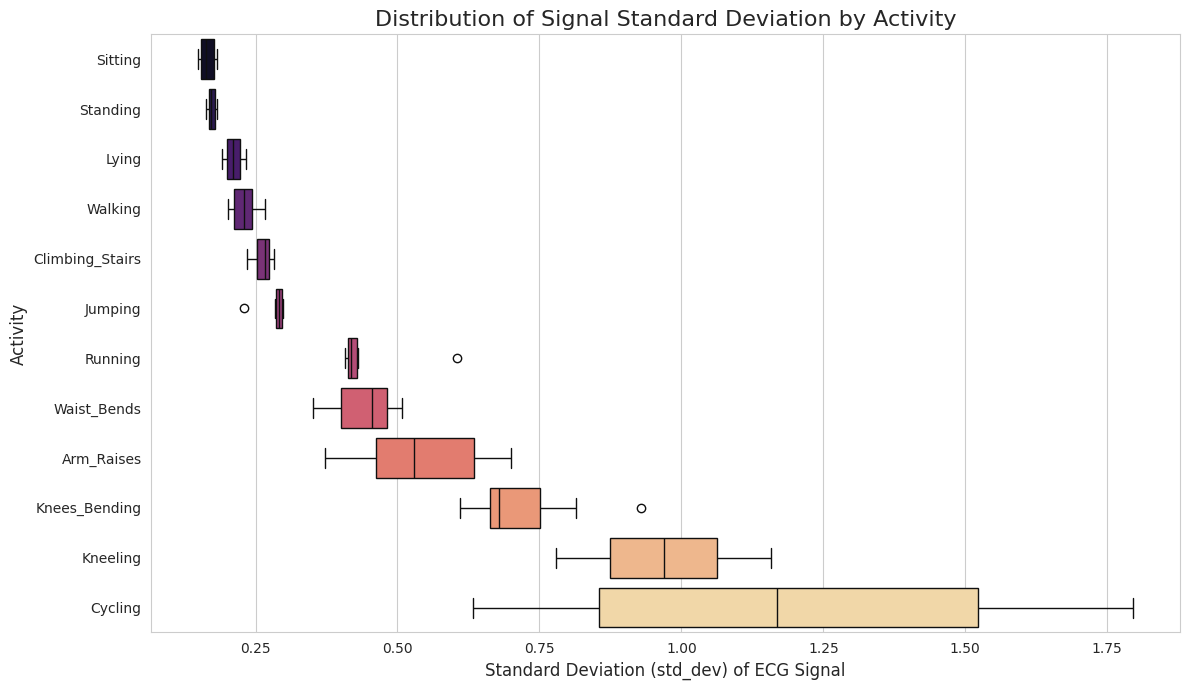

In [16]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='std_dev', y='activity_label', data=feature_df,
            order=feature_df.groupby('activity_label')['std_dev'].median().sort_values().index,
            palette='magma')
plt.title('Distribution of Signal Standard Deviation by Activity', fontsize=16)
plt.xlabel('Standard Deviation (std_dev) of ECG Signal', fontsize=12)
plt.ylabel('Activity', fontsize=12)
plt.tight_layout()
plt.show()

***Feature Importance Bar Chart***

**Theory**: Ensemble models like Random Forest can calculate the relative importance of each feature in their decision-making process. This "importance" is typically measured by how much a feature contributes to reducing impurity (e.g., Gini impurity) across all the decision trees in the forest. Plotting these scores helps us understand which features our model found most predictive.

/tmp/ipython-input-3944378500.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='rocket')


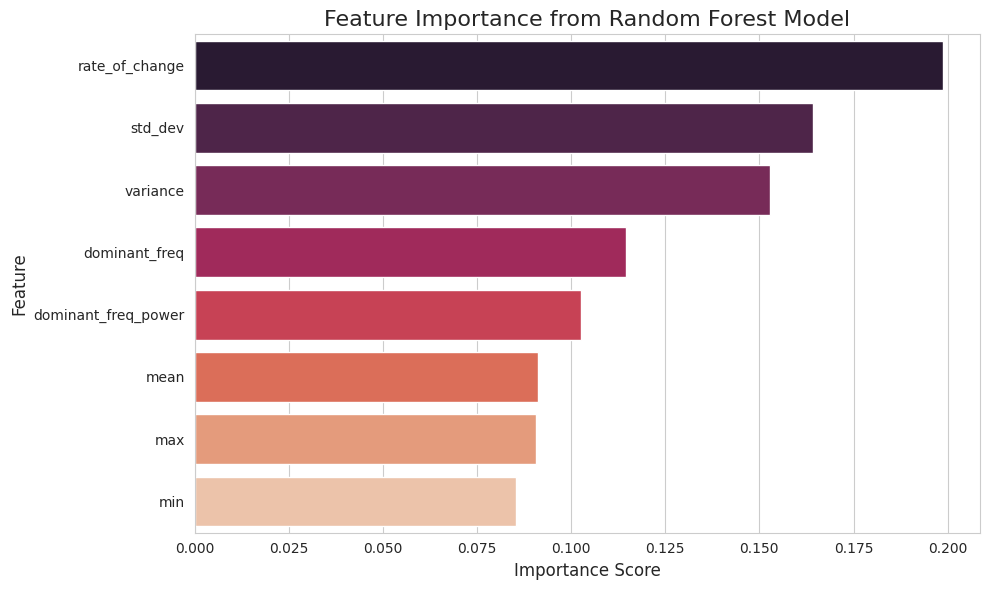

In [18]:
# Assumes 'best_model' is your trained RandomForestClassifier
importances = model.feature_importances_
feature_names = X_train.columns

# Create a dataframe for plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='rocket')
plt.title('Feature Importance from Random Forest Model', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

***Confusion Matrix Heatmap***

**Theory**: A confusion matrix is a table used to evaluate the performance of a classification model. The rows represent the actual (true) classes, while the columns represent the predicted classes.

Diagonal elements show the number of points for which the predicted label is equal to the true label (correct predictions).

Off-diagonal elements are those that are mislabeled.
It provides a far more detailed view than accuracy alone, as it shows the specific confusion between classes.

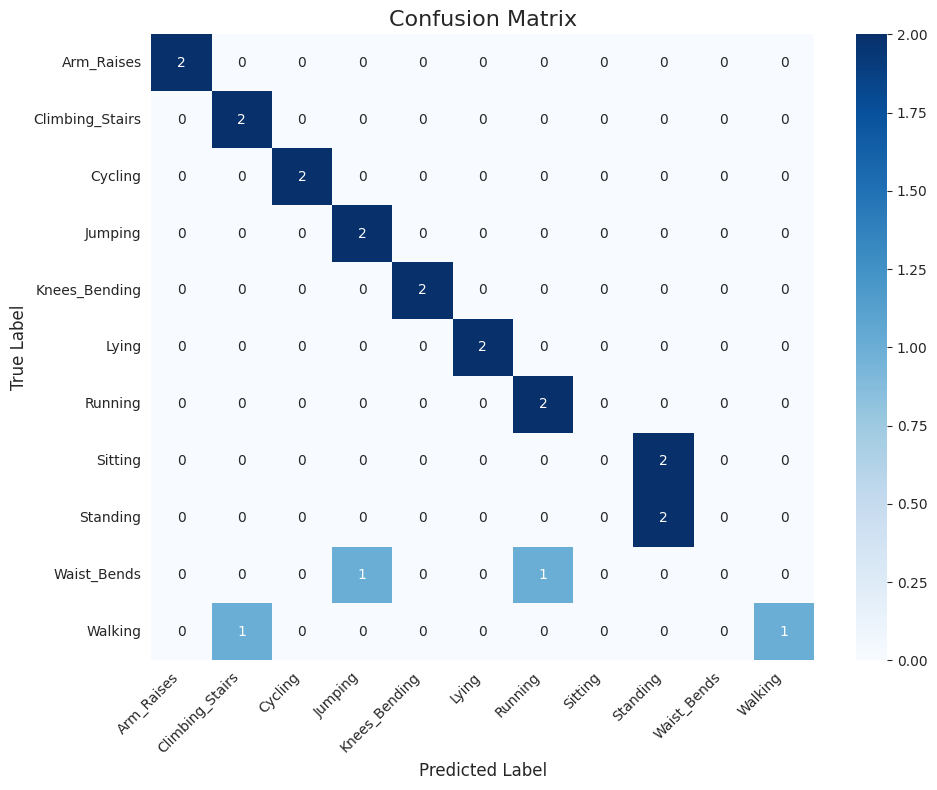

In [20]:
# Get predictions on the test set
y_pred = model.predict(X_test)
# Get the unique sorted labels for the matrix axes
labels = sorted(y_test.unique())

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

***K-Means Clusters Visualized with PCA***

**Theory**: Our feature space has many dimensions (one for each feature), making it impossible to visualize directly. Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms the data into a new coordinate system. The new axes, or "principal components," are orthogonal and are ordered by the amount of variance in the data they capture. By plotting the first two principal components, we can view a 2D "shadow" of our high-dimensional data, revealing its intrinsic structure.

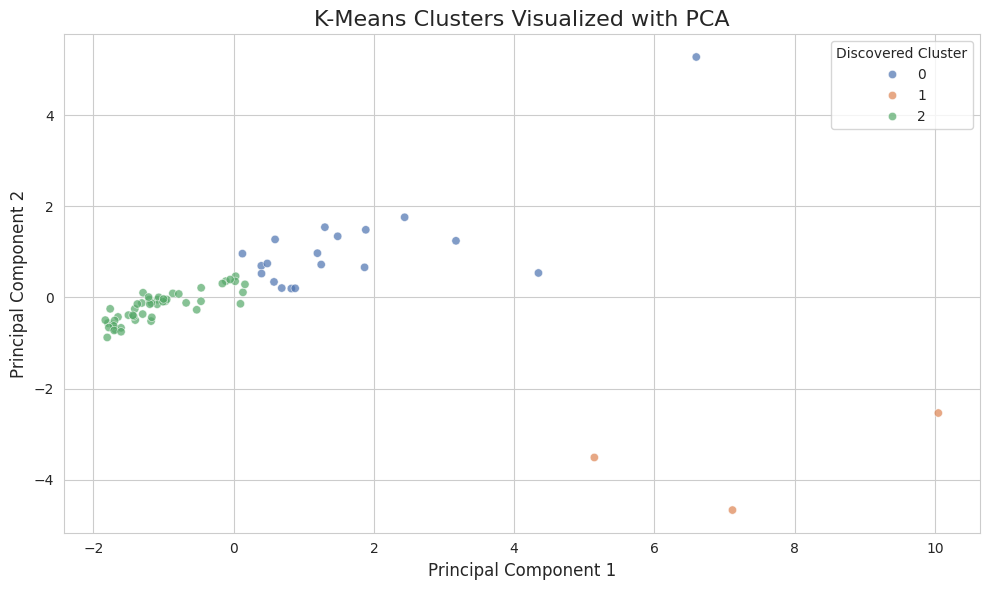

In [21]:
# Assumes 'feature_df' has a 'cluster' column and you have X_scaled
# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled) # Use the scaled data

# Create a new DataFrame for plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'], index=feature_df.index)
pca_df['Cluster'] = feature_df['cluster']
pca_df['Activity'] = feature_df['activity_label']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='deep', alpha=0.7)
plt.title('K-Means Clusters Visualized with PCA', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Discovered Cluster')
plt.tight_layout()
plt.show()

#### ***Conclusion***

In this comprehensive analysis, we have successfully navigated the complete machine learning workflow. We started with raw, complex time-series data and systematically transformed it into a valuable asset. We engineered meaningful features, trained a predictive model to classify activities with a clear evaluation of its performance, and used unsupervised techniques to discover hidden data structures without relying on labels.

The final visualizations provide a powerful narrative, showing not just what the model predicts, but why (Feature Importance), how it errs (Confusion Matrix), and what the underlying structure of the data looks like (PCA Clustering). This pipeline serves as a robust template for tackling similar signal processing and time-series analysis problems in any domain.